# Finite Elements on a Pac-Man Mesh
This example demonstrates how to set up and solve a finite element problem on a
punctured mesh. 
The model problem under consideration is a simple diffusion-reaction problem
\begin{align*}
	-\nabla\cdot(a \, \nabla u) + c \, u &= f \quad \text{in } \Omega, \\
	u &= 0 \quad \text{on } \partial\Omega,
\end{align*}
where $a, c$ are constant scalars and $f$ is a polynomial.
The associated weak form is
\begin{align*}
	\int_\Omega a \, \nabla u \cdot \nabla v \, dx
	+ \int_\Omega c \, u \, v \, dx
	&= \int_\Omega f \, v \, dx
	\quad \forall v \in H^1_0(\Omega).
\end{align*}
In previous examples, we saw that we can evalate these integrals on each cell
$K$ in a mesh $\mathcal{T}$ of the domain $\Omega$, provided that $u$ and $v$
are elements of a *local Poisson space* $V_p(K)$.
We define the *global Poisson space* $V_p(\mathcal{T})$ as the space of
continuous functions in $H^1_0(\Omega)$ whose restriction to each cell $K$ is
an element of $V_p(K)$.
By constructing a basis $\{\phi_1, \dots, \phi_N\}$ of $V_p(\mathcal{T})$ by 
continuously "stitching" the local basis functions together,
we seek a finite element solution $\tilde{u} \in V_p(\mathcal{T})$ such that
\begin{align*}
	&\tilde{u} = \sum_{i=1}^N u_i \, \phi_i,
	\\
	&\int_\Omega a \, u_i \nabla \phi_i \cdot \nabla \phi_j \, dx
	+ \int_\Omega c \, u_i \, \phi_i \, \phi_j \, dx
	= \int_\Omega f \, \phi_j \, dx
\end{align*}

We begin by importing the usual packages, as well as the `tqdm` package for
displaying progress bars.

*Note:* This example can be run without the `tqdm` package by setting 
`verbose=False` below.

In [1]:
# imports

import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's set a few parameters before we go any further. 
`deg` is the polynomial degree of global Poisson space,
`n` is edge sampling parameter (as used in previous examples),
and `verbose` controls how much output we see.

**(!) WARNING:** 
Higher order spaces (`deg > 1`) are still under development.

In [2]:
deg = 1
n = 64
verbose = True

## Mesh construction
The mesh we will use for this example was constructed in 
[Example 0](ex0-mesh-building.ipynb).
For convenience, the same mesh can be constructed by calling the `pacman_mesh`
function in the `mesh.meshlib` module.

In [3]:
# define mesh
# T = pf.meshlib.pacman(verbose=verbose)
T = pf.meshlib.pacman_subdiv(verbose=verbose)

Building planar mesh...
planar_mesh:
	num_verts: 17
	num_edges: 25
	num_cells: 11


## Build global function space 
The global function space $V_p(\mathcal{T})\subset H^1(\Omega)$ 
is the space of continuous functions such that each function belongs to 
$V_p(K)$ when restricted to any cell $K\in\mathcal{T}$.
(Note that we use `deg` to denote the polynomial degree $p$.)

To proceed with the computation, we define the quadrature scheme(s) used to 
parameterize the edges of the mesh.

In [4]:
# TODO: this should really be done automatically
q_trap = pf.quad(qtype='trap', n=n)
q_kress = pf.quad(qtype='kress', n=n)
quad_dict = {'kress': q_kress, 'trap': q_trap}

The global function space `V` is built from the mesh `T`, along with the `deg`
parameter and the information necessary to parameterize the edges of the mesh.

In [5]:
V = pf.global_function_space(T=T, deg=deg, quad_dict=quad_dict, verbose=verbose)

Building edge spaces...


100%|██████████| 25/25 [00:00<00:00, 469.12it/s]

global_function_space:
	deg: 1
	num_funs: 38
	num_bubb_funs: 0
	num_vert_funs: 17
	num_edge_funs: 21


## Define a bilinear form
The bilinear form 
\begin{align*}
	B(u,v) = 
	a \, \int_\Omega \nabla u \cdot \nabla v ~dx
	+ c \, \int_\Omega u \, v ~dx
\end{align*}
and the right-hand side linear functional
\begin{align*}
	F(v) = \int_\Omega f \, v ~dx
\end{align*}
are declared as follows,
with `diffusion_coefficient` $a = 1$, 
`reaction_coefficient` $c = 1$,
and `rhs_poly` $f(x) = 1 \cdot x^{(0, 0)}$.

In [6]:
B = pf.bilinear_form(
	diffusion_constant=1.0,
	reaction_constant=1.0,
	rhs_poly=pf.polynomial([[1.0, 0, 0]])
)
print(B)

bilinear_form:
	diffusion_constant: 1.0
	reaction_constant: 1.0
	rhs_poly: + (1.0)   


## Set up the finite element solver
A finite element solver needs two things: the global function space and the bilinear form. 

In [7]:
S = pf.solver(V, B)

To assemble the matrix and right-hand side vector for the global system, we 
call the `assemble()` method.
Zero Dirichlet boundary conditions are incorporated by default.

This can take a while. You may want to grab a cup of coffee.

In [8]:
S.assemble(verbose=verbose)

Cell      1 /     11
Setting up Nyström solver... 1024 sampled points on 8 edges
Computing function metadata...


100%|██████████| 9/9 [01:16<00:00,  8.54s/it]


Finding interior values...


100%|██████████| 9/9 [00:19<00:00,  2.18s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 9/9 [01:11<00:00,  7.95s/it]


Cell      2 /     11
Setting up Nyström solver... 512 sampled points on 4 edges
Computing function metadata...


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


Finding interior values...


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Cell      3 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 307.76it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 98.62it/s]


Cell      4 /     11
Setting up Nyström solver... 1152 sampled points on 9 edges
Computing function metadata...


100%|██████████| 15/15 [02:15<00:00,  9.04s/it]


Finding interior values...


100%|██████████| 15/15 [01:12<00:00,  4.83s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 15/15 [02:18<00:00,  9.26s/it]


Cell      5 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 94.69it/s]


Finding interior values...


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 201.30it/s]


Cell      6 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 367.79it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 207.10it/s]


Cell      7 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 519.08it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 206.16it/s]


Cell      8 /     11
Setting up Nyström solver... 1152 sampled points on 9 edges
Computing function metadata...


100%|██████████| 11/11 [01:42<00:00,  9.31s/it]


Finding interior values...


100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 11/11 [01:42<00:00,  9.33s/it]


Cell      9 /     11
Setting up Nyström solver... 768 sampled points on 6 edges
Computing function metadata...


100%|██████████| 12/12 [00:51<00:00,  4.29s/it]


Finding interior values...


100%|██████████| 12/12 [00:30<00:00,  2.51s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 12/12 [00:51<00:00,  4.26s/it]


Cell     10 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 505.95it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 84.42it/s]


Cell     11 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 394.36it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 291.01it/s]


The `matplotlib.pyplot` module has a handy function for inspecting the sparsity
pattern of a matrix.  Let's take a look at the global matrix.

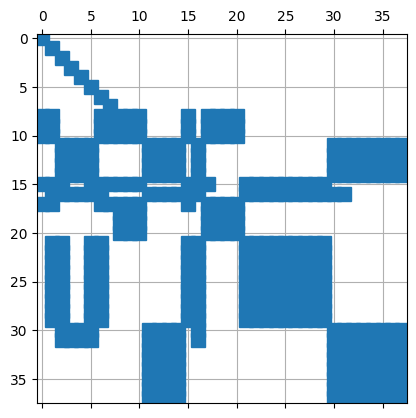

In [9]:
plt.figure()
plt.spy(S.glob_mat)
plt.grid('minor')
plt.show()

## Solving the global linear system
To solve the system we worked hard to set up, we can call the `solve()` method
on the `solver` object.

In [10]:
S.solve()

## Plot solution
We can visualize the solution by calling the `plot_solution()` method on the 
solver object.
There are two types of plots available: 
a conventional contour plot (`fill=False`)
or a heat map (`fill=True`).
To view the figure in this notebook, set `show_fig = True`.
To save it to a file, set `save_fig = True` and select a filename.

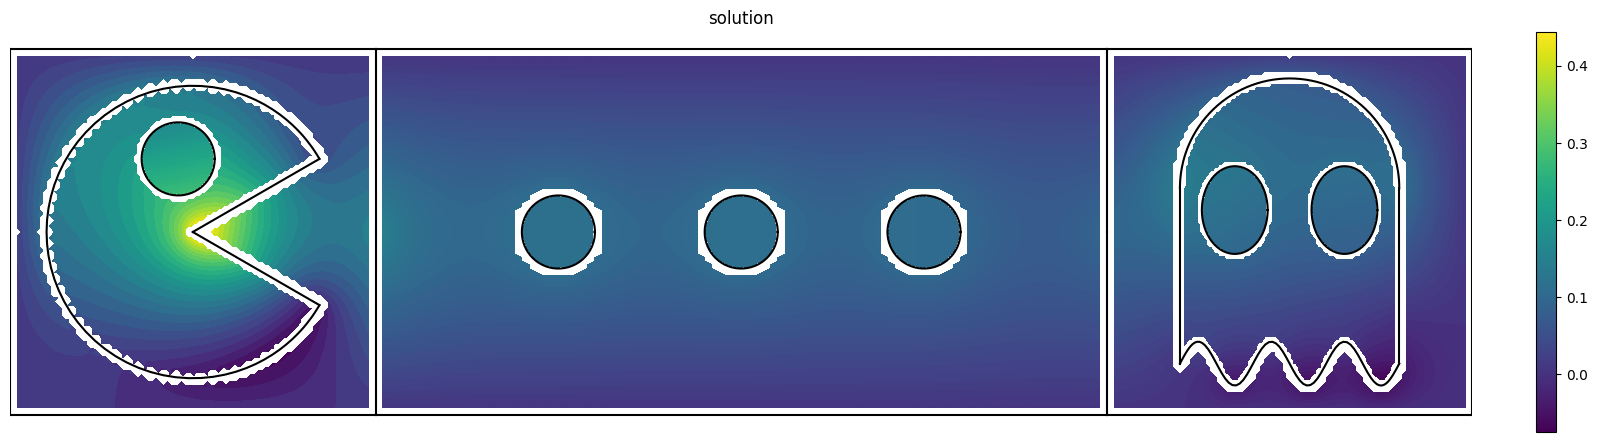

In [11]:
S.plot_solution(
	  title='solution',
	  show_fig=True,
	  save_fig=False,
	  filename='out/png/solution_heat.png',
	  fill=True
)

## Plot global basis functions
Let's take a look at the global basis functions by using the 
`plot_linear_combo()` method.

Plotting basis functions...


  0%|          | 0/38 [00:00<?, ?it/s]

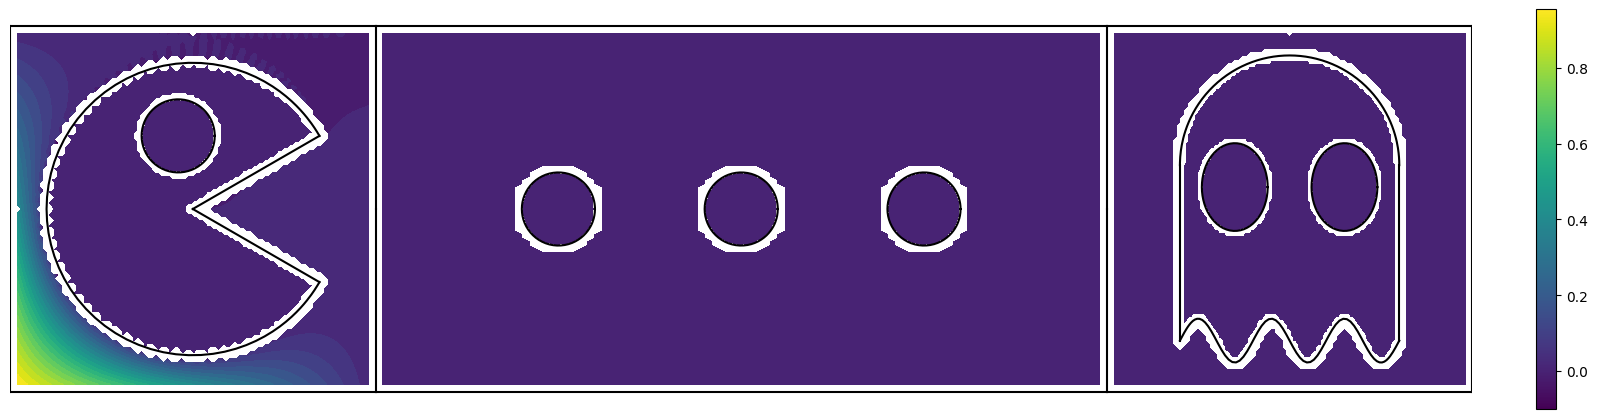

  3%|▎         | 1/38 [00:05<03:23,  5.51s/it]

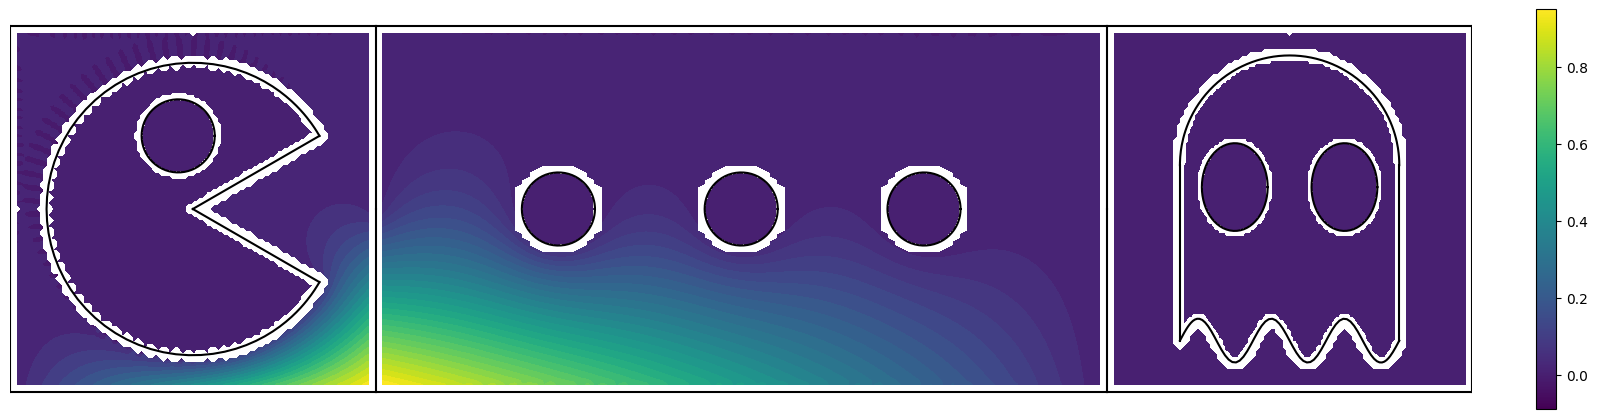

  5%|▌         | 2/38 [00:11<03:21,  5.61s/it]

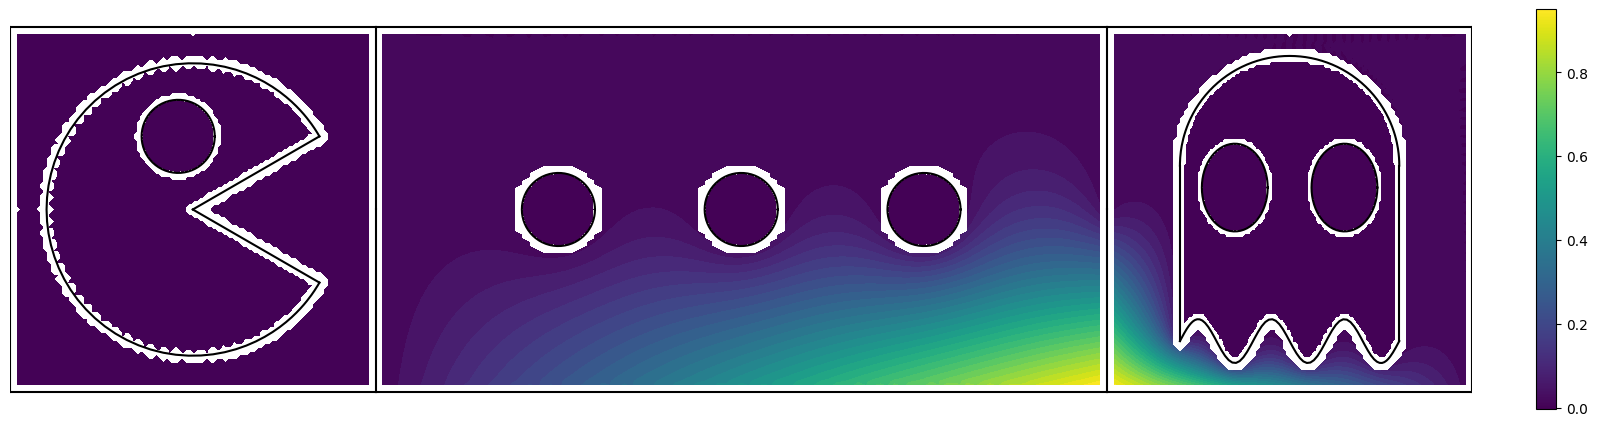

  8%|▊         | 3/38 [00:16<03:14,  5.55s/it]

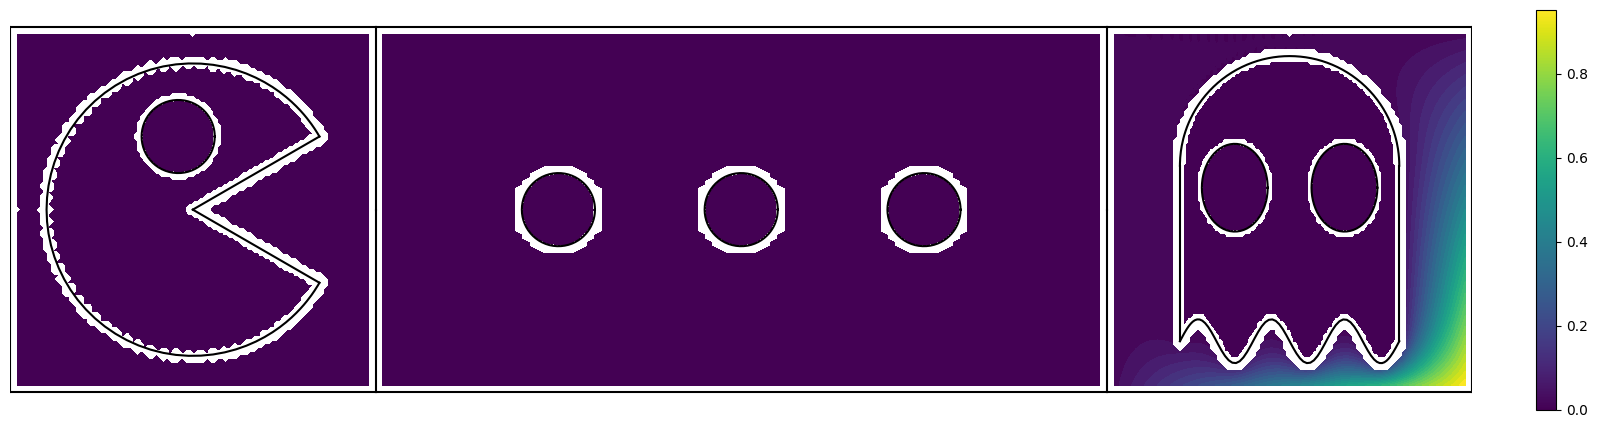

 11%|█         | 4/38 [00:22<03:08,  5.56s/it]

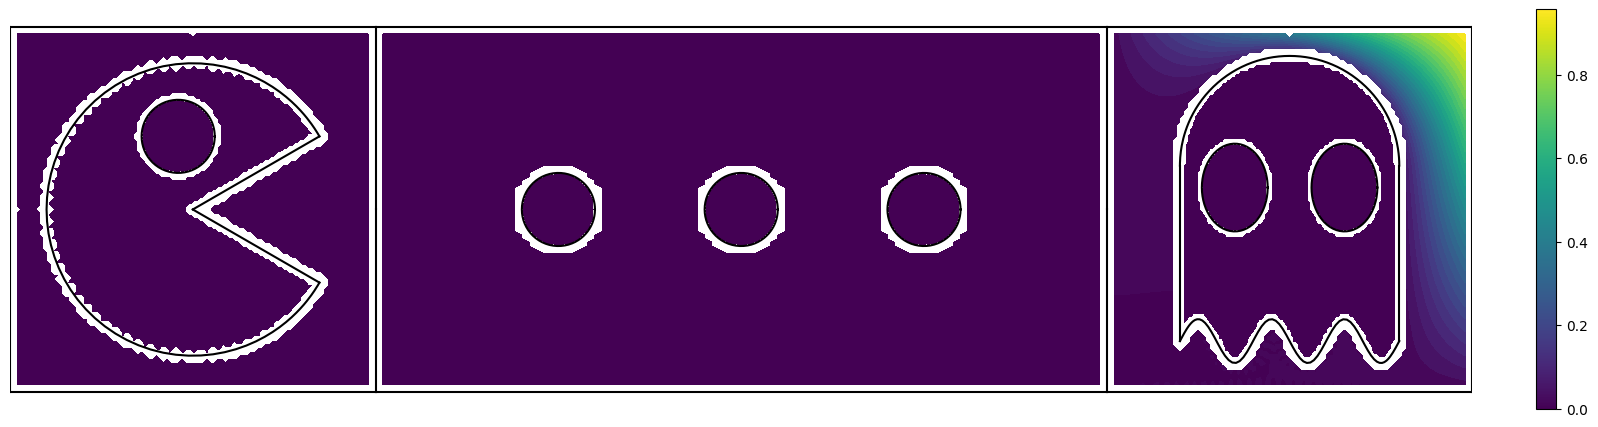

 13%|█▎        | 5/38 [00:27<03:03,  5.56s/it]

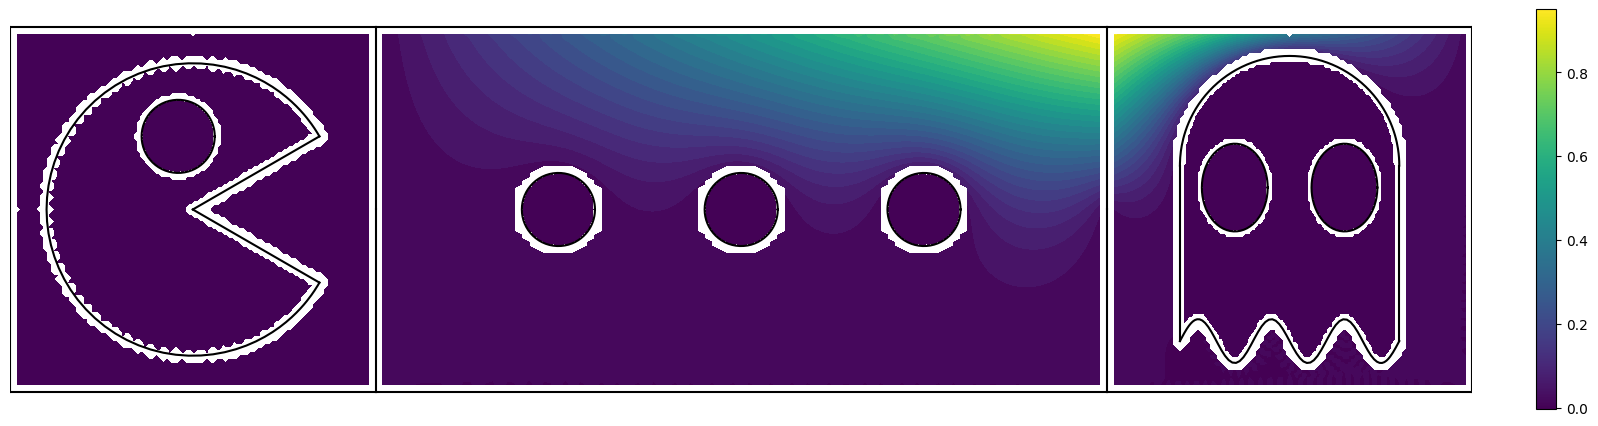

 16%|█▌        | 6/38 [00:33<02:59,  5.61s/it]

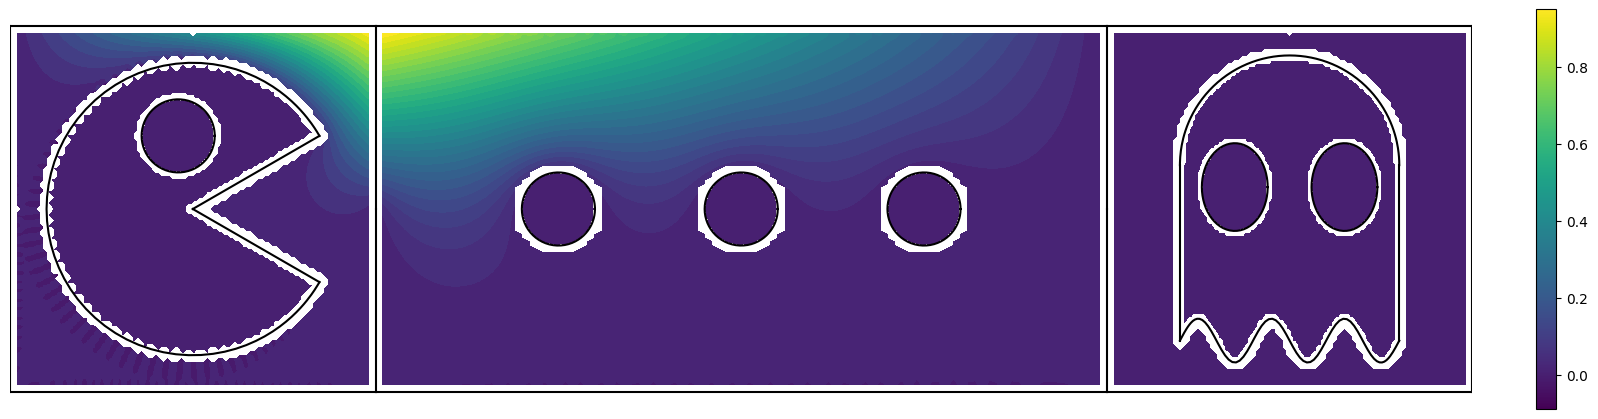

 18%|█▊        | 7/38 [00:39<02:54,  5.61s/it]

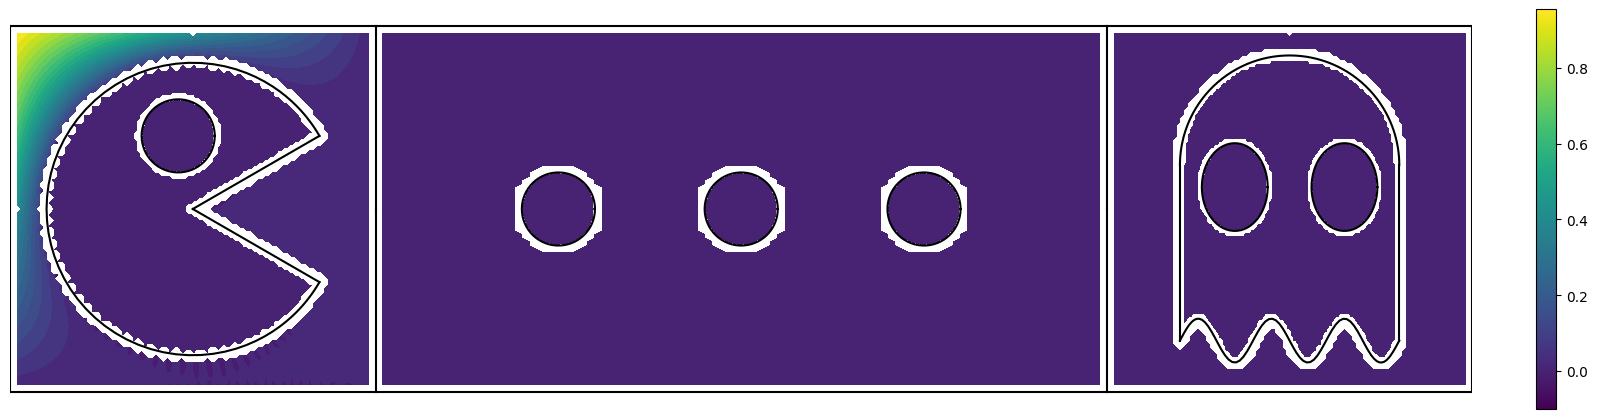

 21%|██        | 8/38 [00:44<02:47,  5.59s/it]

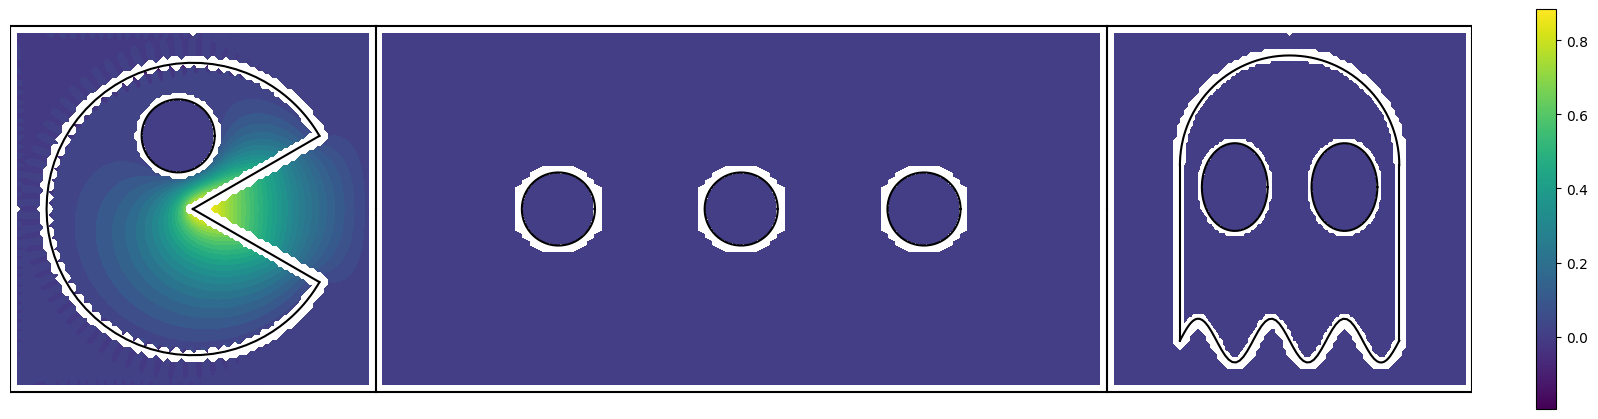

 24%|██▎       | 9/38 [00:50<02:43,  5.65s/it]

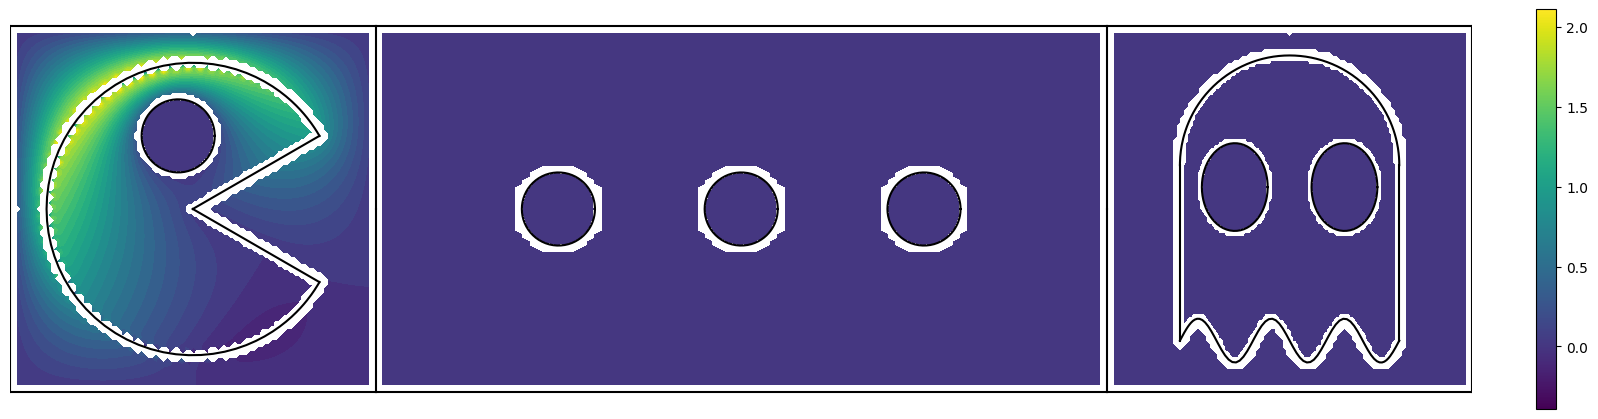

 26%|██▋       | 10/38 [00:56<02:39,  5.70s/it]

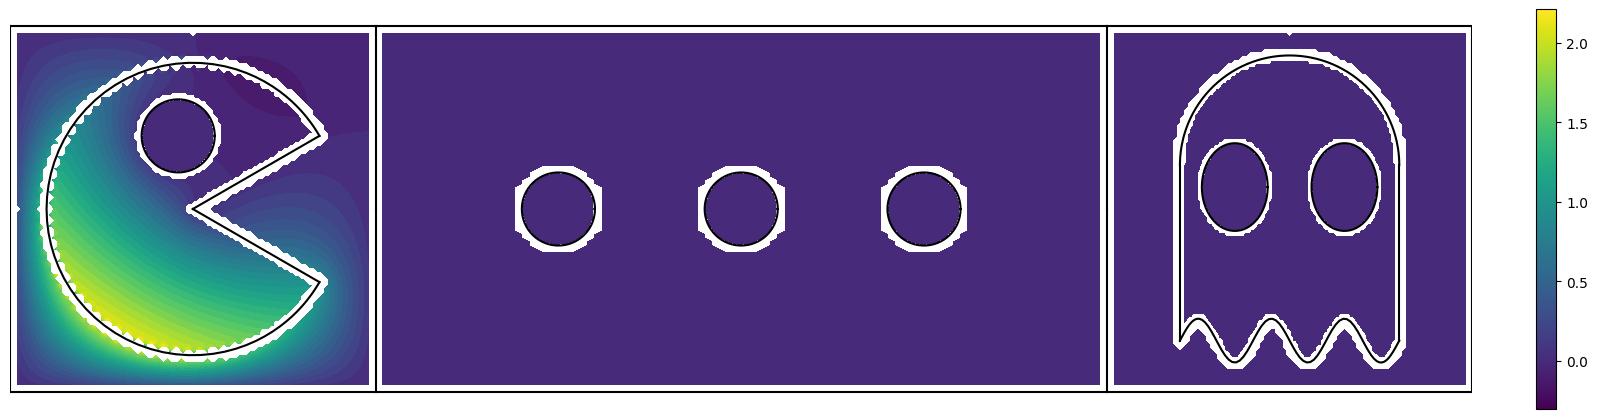

 29%|██▉       | 11/38 [01:01<02:32,  5.64s/it]

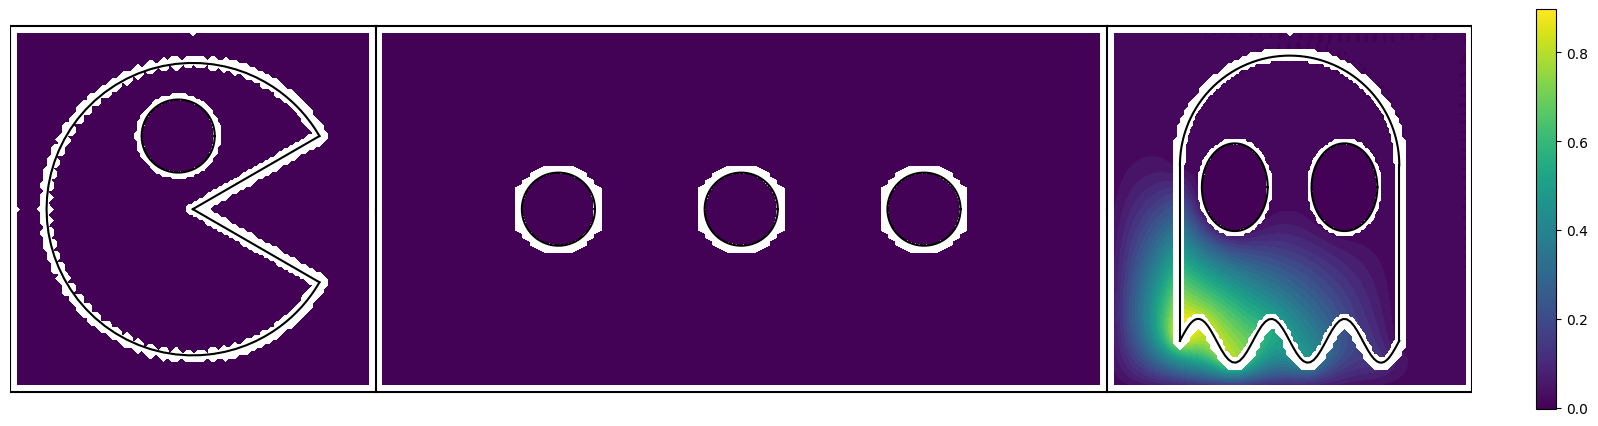

 32%|███▏      | 12/38 [01:07<02:30,  5.81s/it]

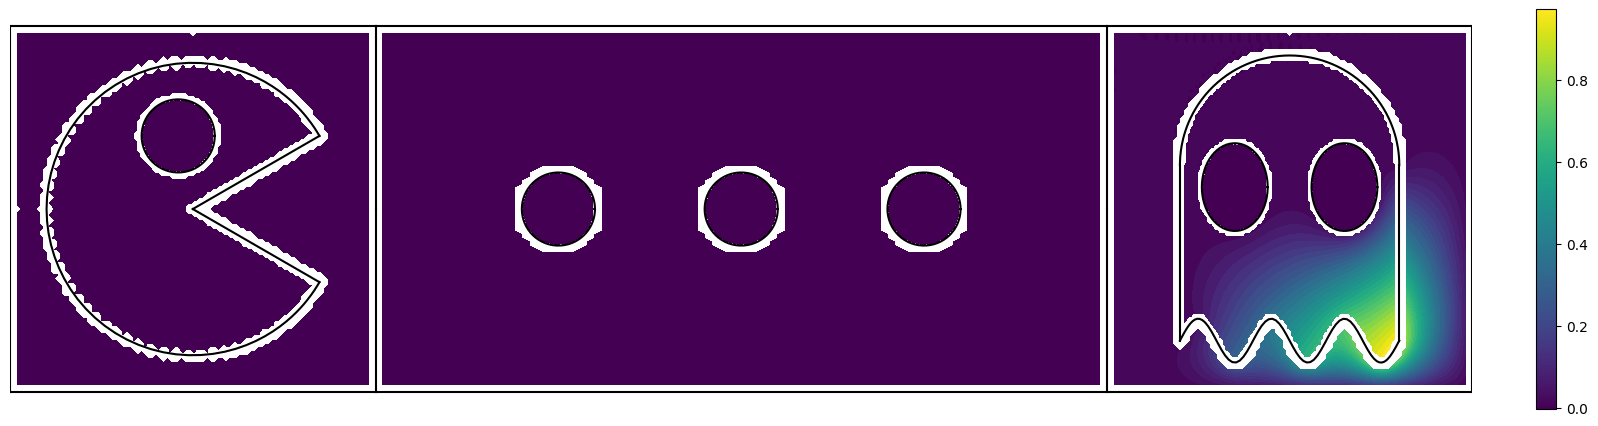

 34%|███▍      | 13/38 [01:13<02:24,  5.78s/it]

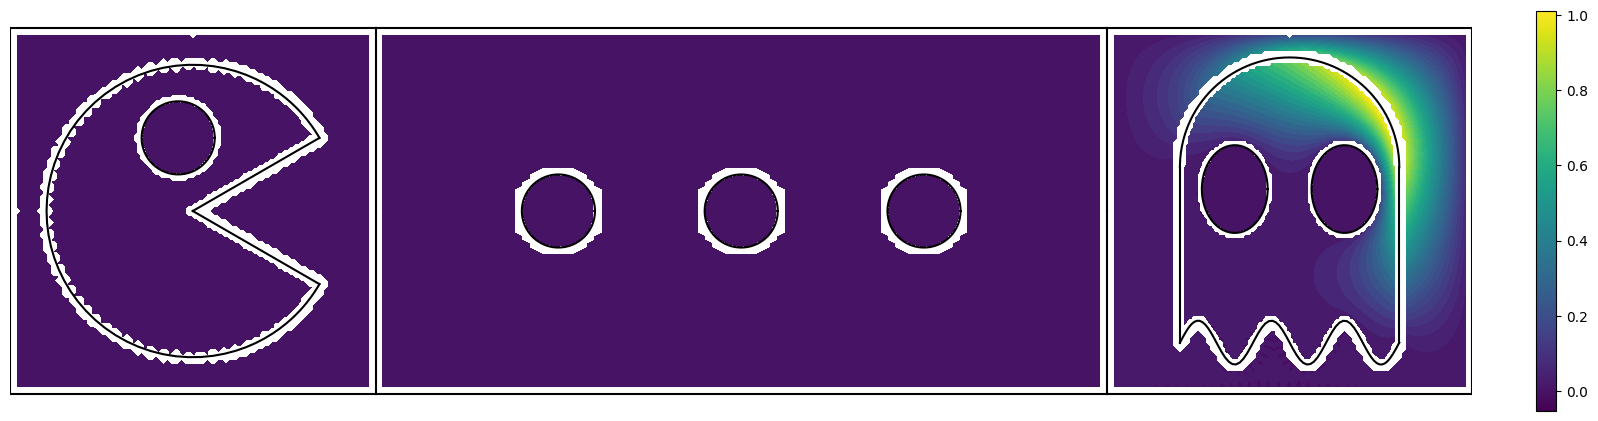

 37%|███▋      | 14/38 [01:19<02:18,  5.77s/it]

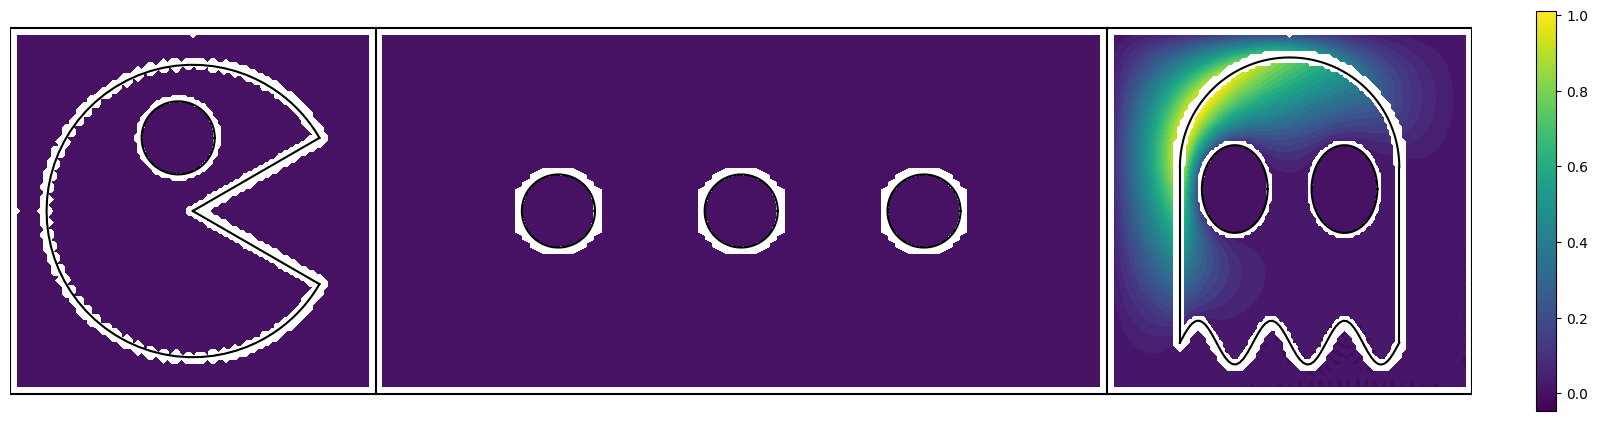

 39%|███▉      | 15/38 [01:25<02:13,  5.80s/it]

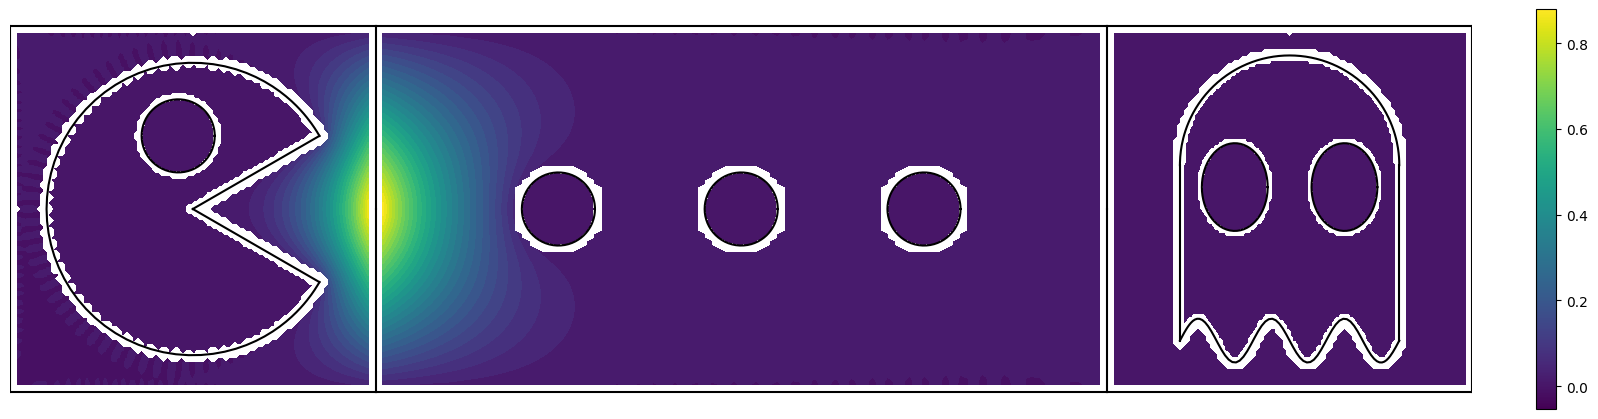

 42%|████▏     | 16/38 [01:30<02:06,  5.75s/it]

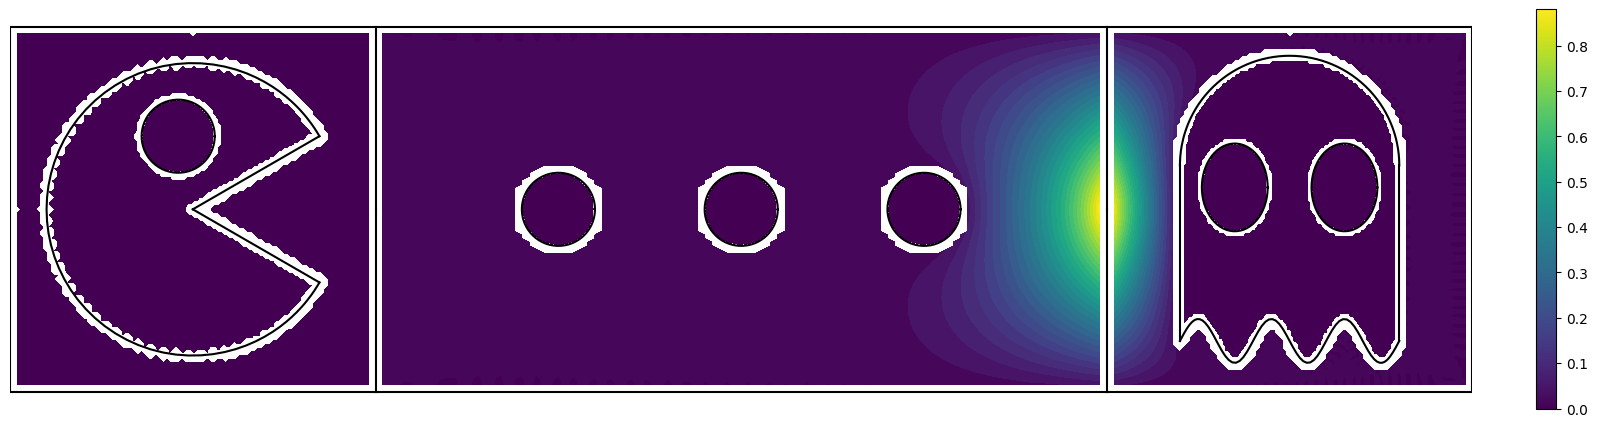

 45%|████▍     | 17/38 [01:36<01:59,  5.68s/it]

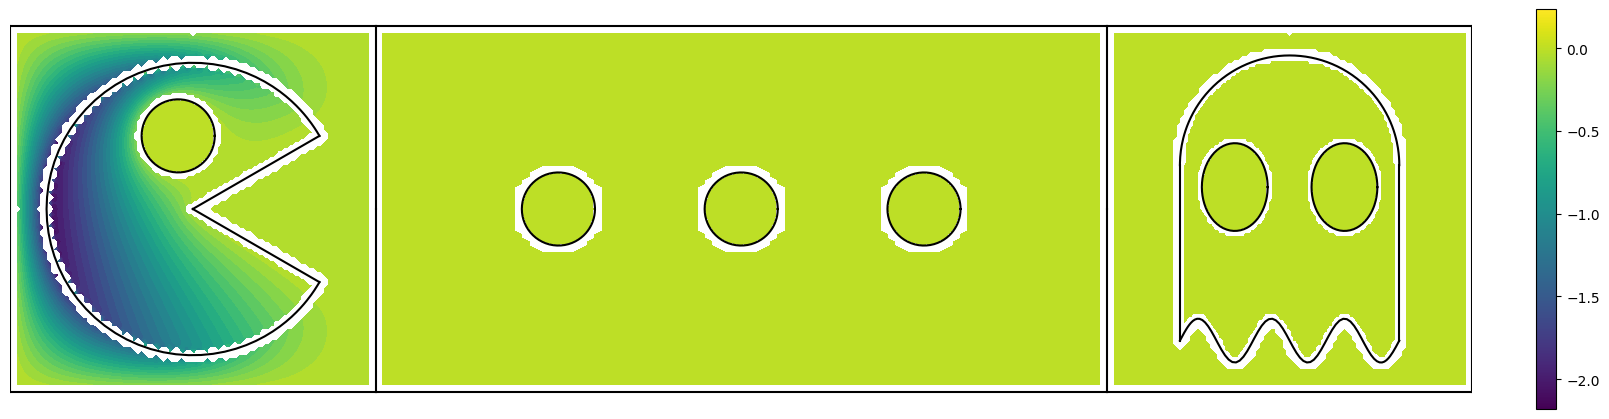

 47%|████▋     | 18/38 [01:43<02:00,  6.01s/it]

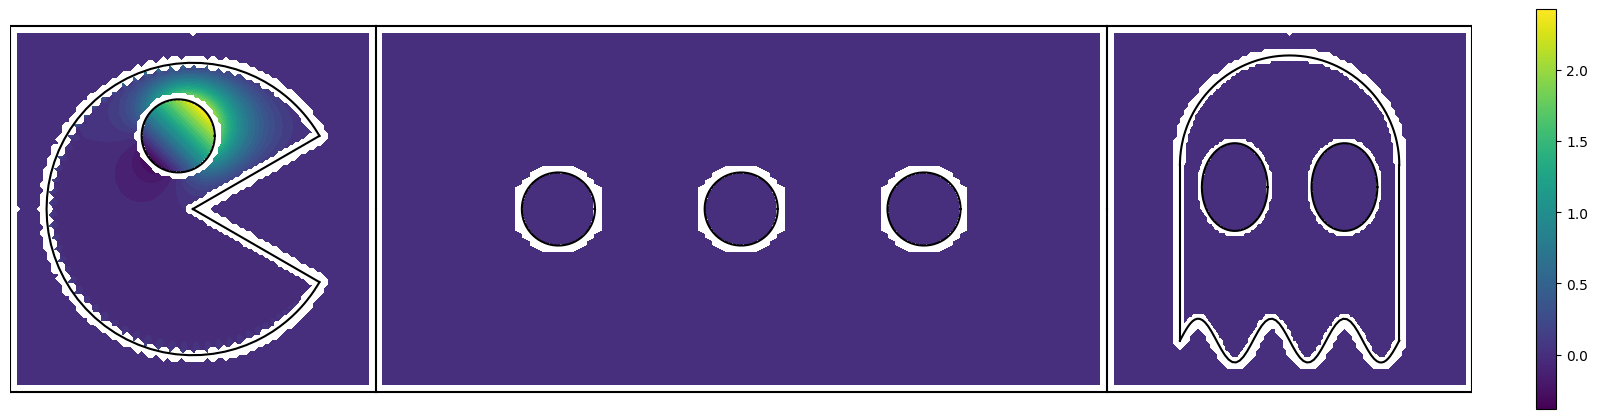

 50%|█████     | 19/38 [01:48<01:51,  5.87s/it]

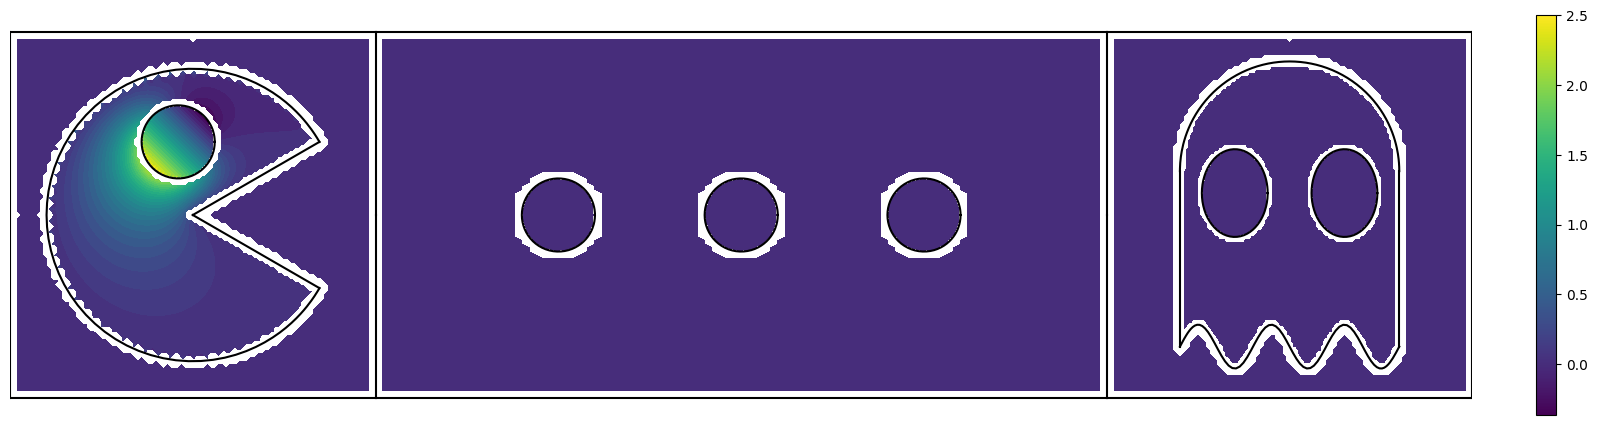

 53%|█████▎    | 20/38 [01:54<01:45,  5.85s/it]

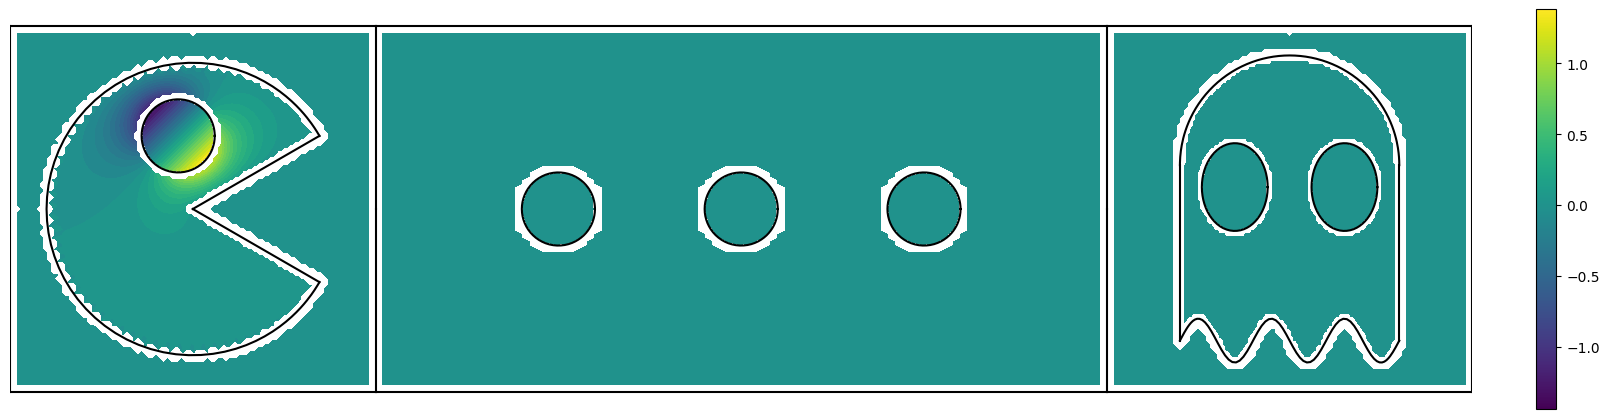

 55%|█████▌    | 21/38 [02:00<01:38,  5.79s/it]

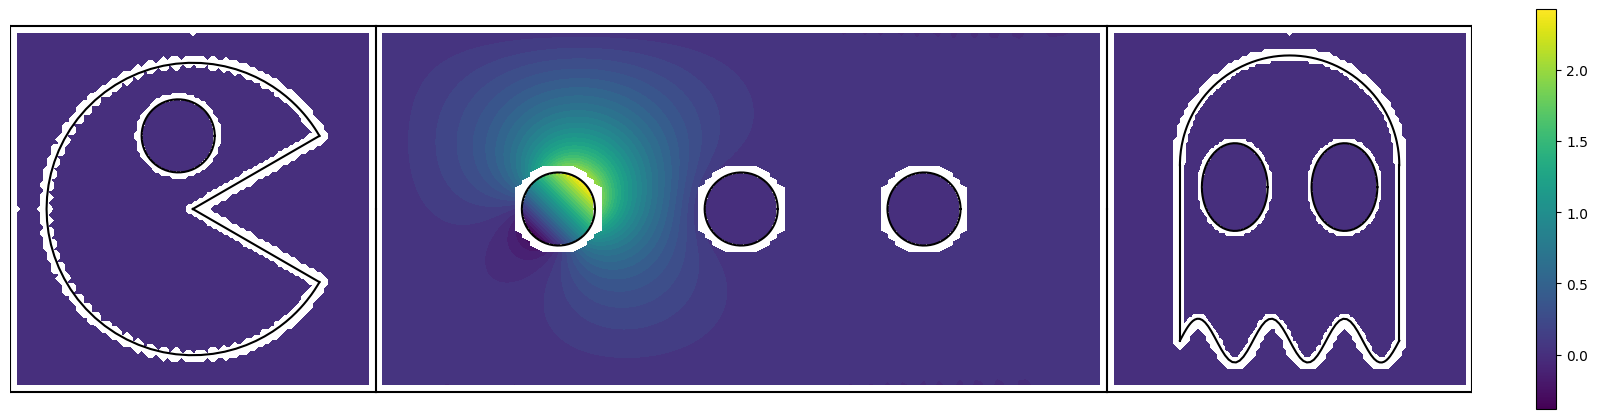

 58%|█████▊    | 22/38 [02:08<01:43,  6.45s/it]

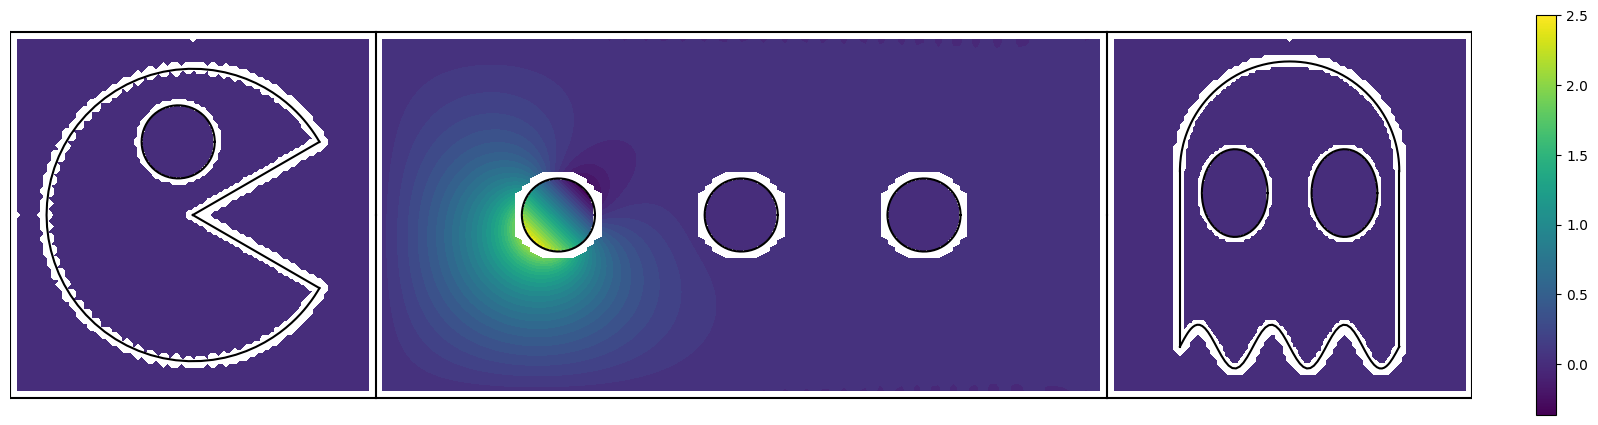

 61%|██████    | 23/38 [02:13<01:31,  6.11s/it]

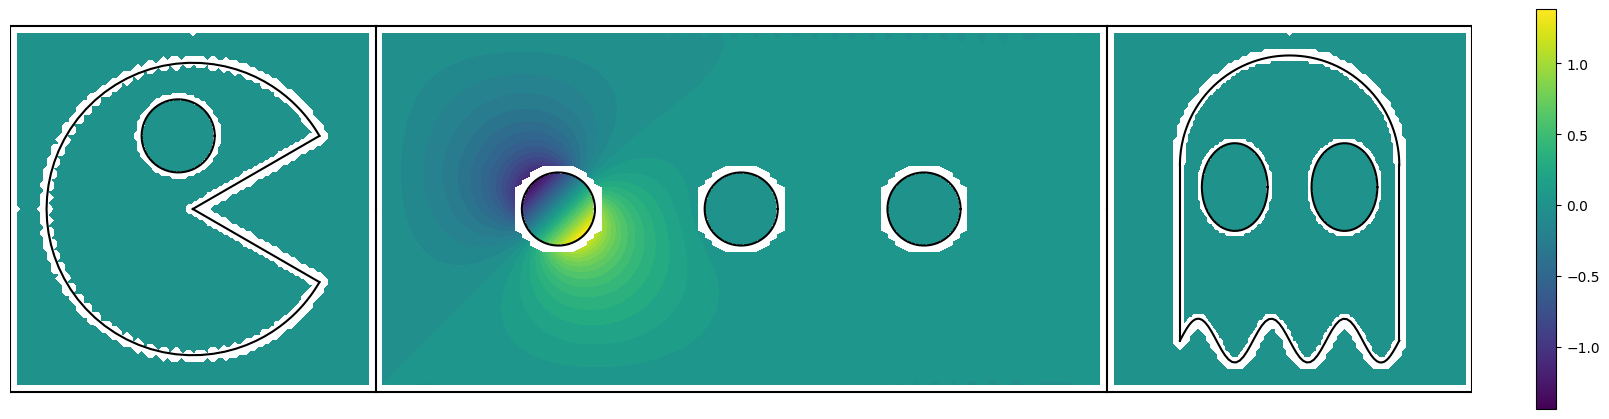

 63%|██████▎   | 24/38 [02:19<01:24,  6.03s/it]

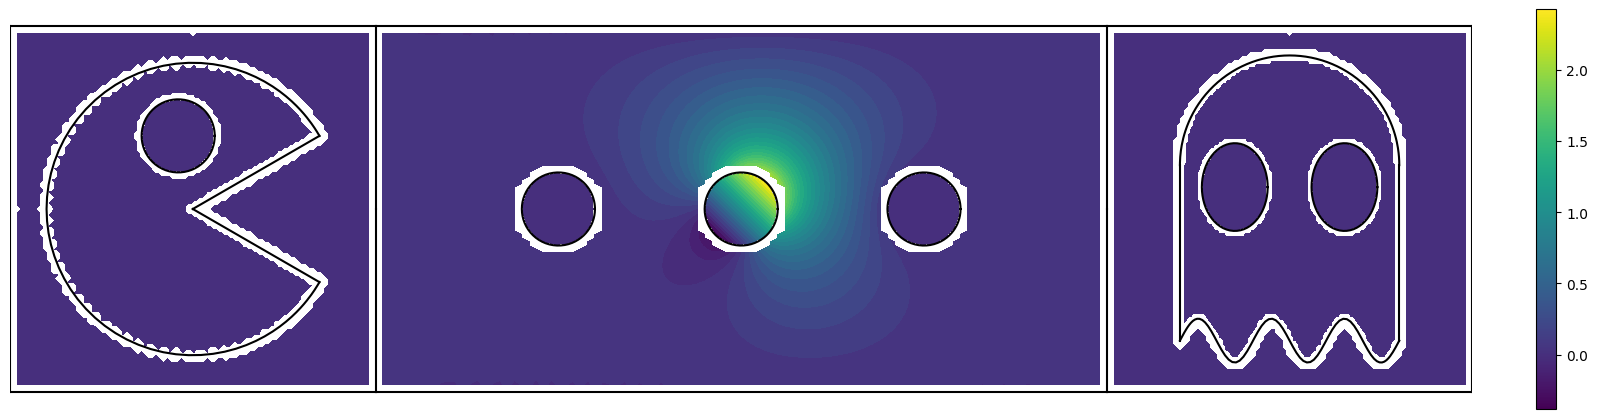

 66%|██████▌   | 25/38 [02:25<01:17,  5.93s/it]

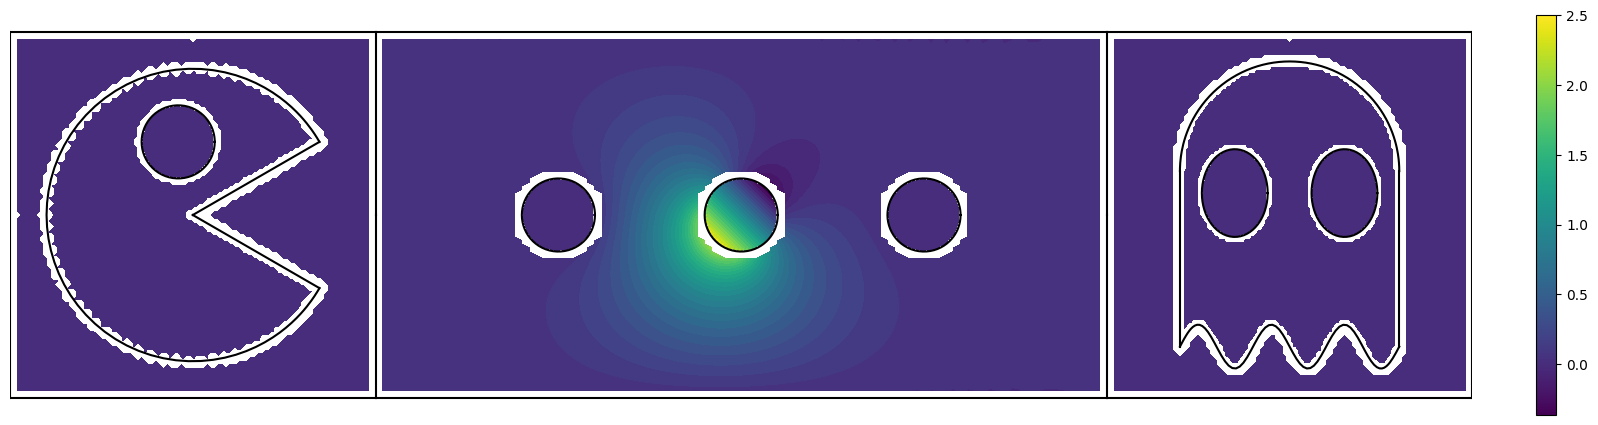

 68%|██████▊   | 26/38 [02:31<01:14,  6.18s/it]

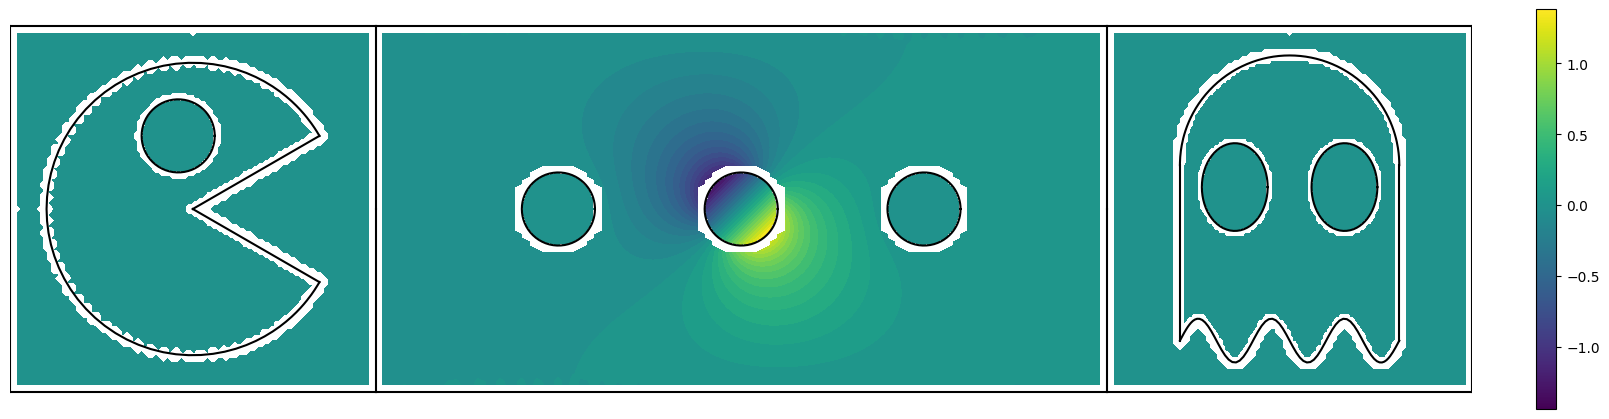

 71%|███████   | 27/38 [02:37<01:06,  6.03s/it]

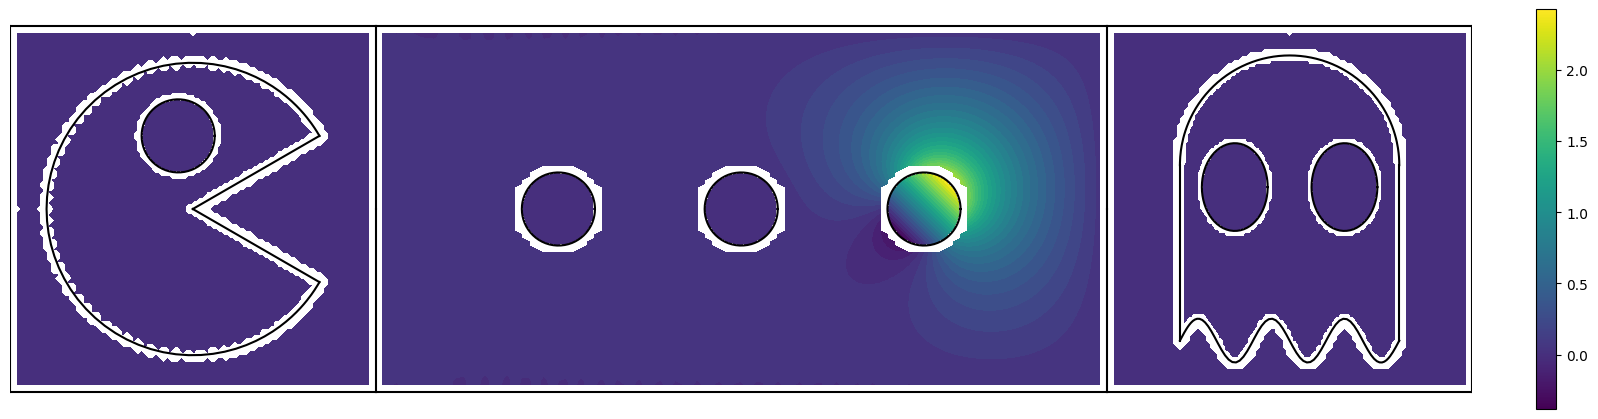

 74%|███████▎  | 28/38 [02:43<00:59,  5.91s/it]

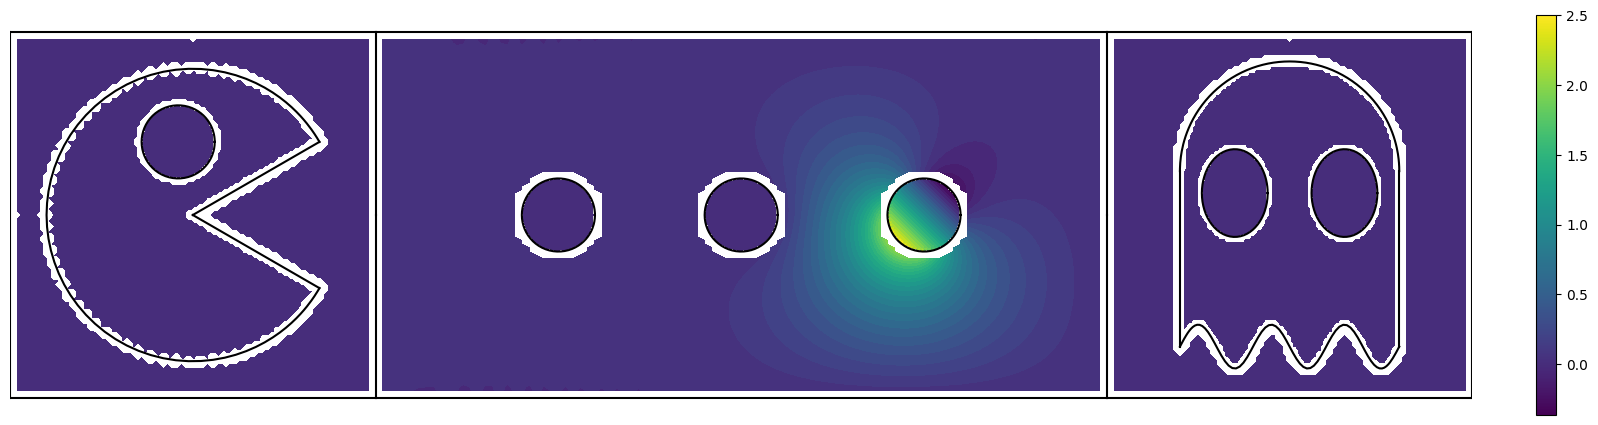

 76%|███████▋  | 29/38 [02:48<00:52,  5.80s/it]

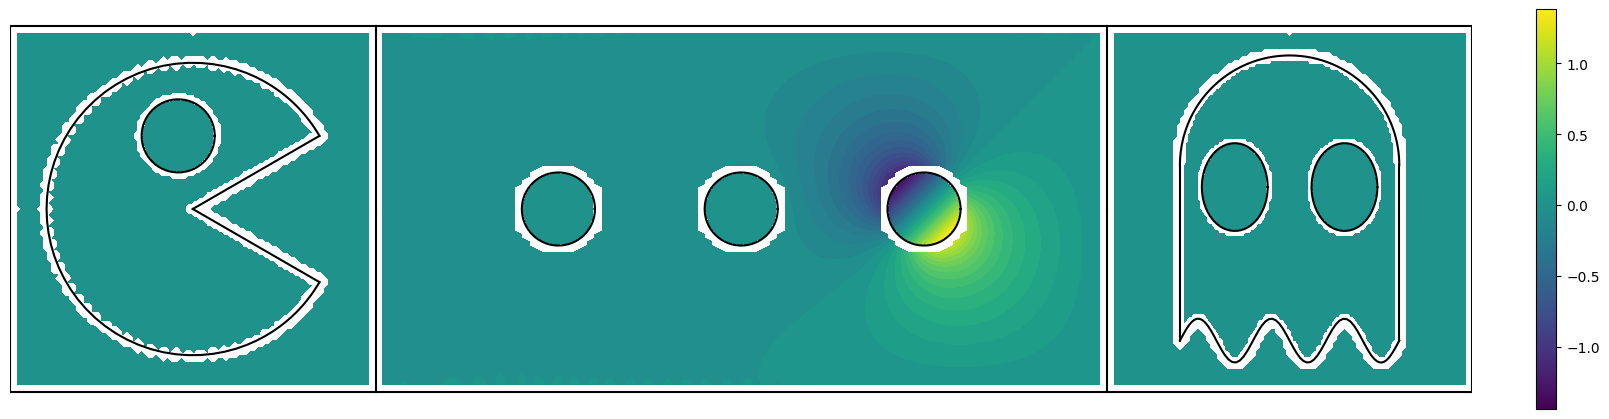

 79%|███████▉  | 30/38 [02:54<00:46,  5.75s/it]

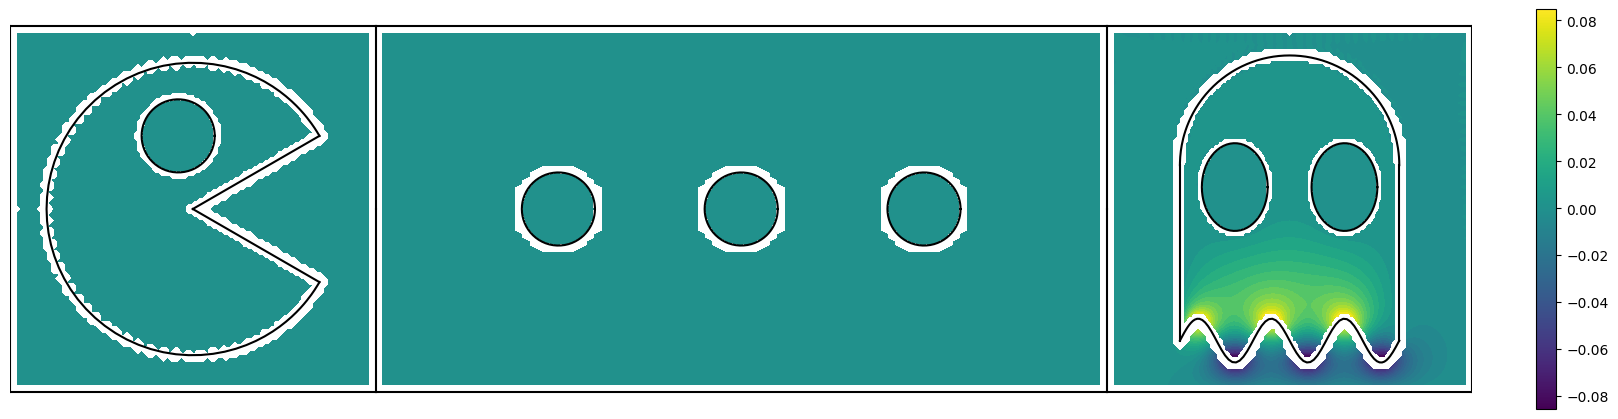

 82%|████████▏ | 31/38 [02:59<00:40,  5.73s/it]

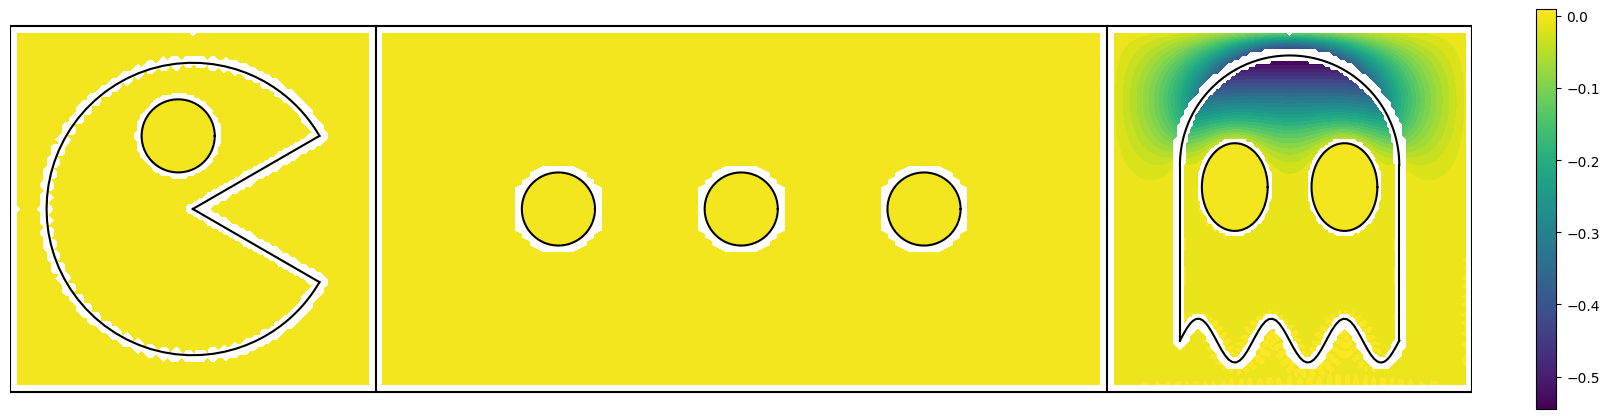

 84%|████████▍ | 32/38 [03:05<00:34,  5.77s/it]

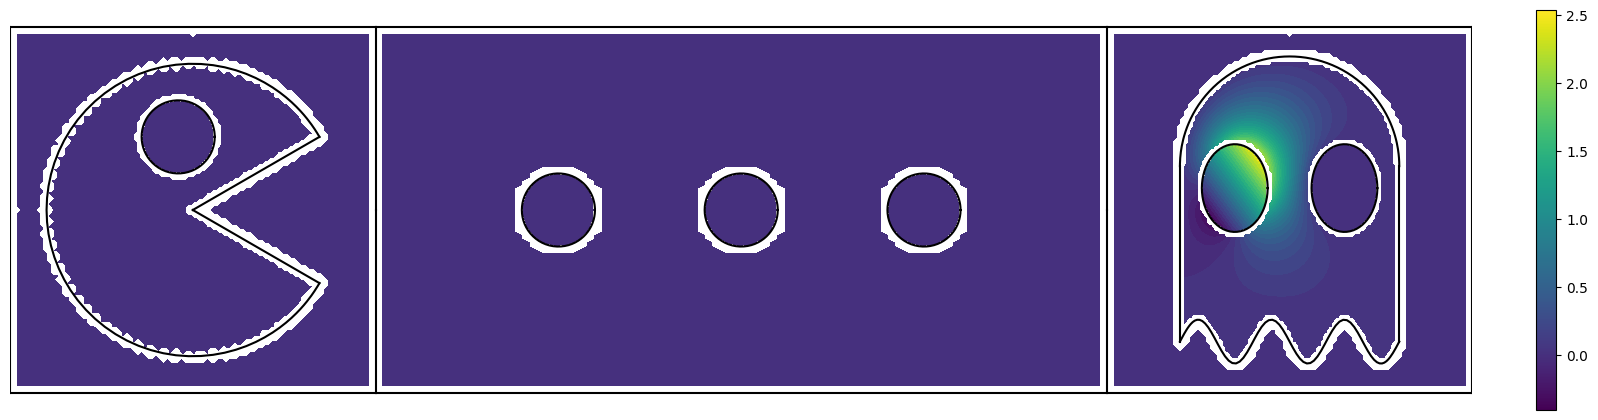

 87%|████████▋ | 33/38 [03:11<00:29,  5.80s/it]

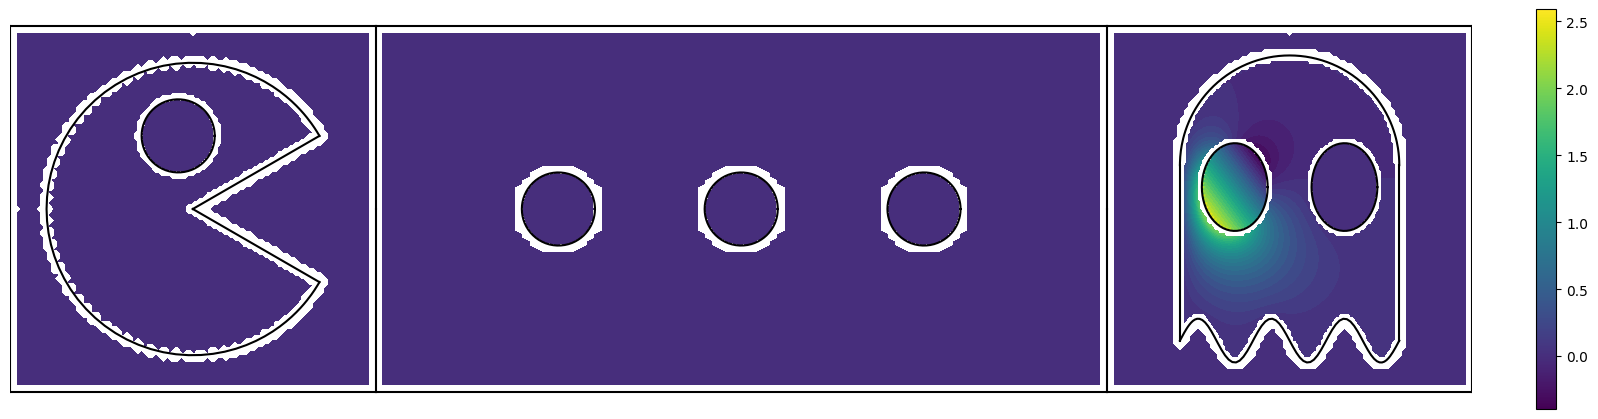

 89%|████████▉ | 34/38 [03:17<00:23,  5.80s/it]

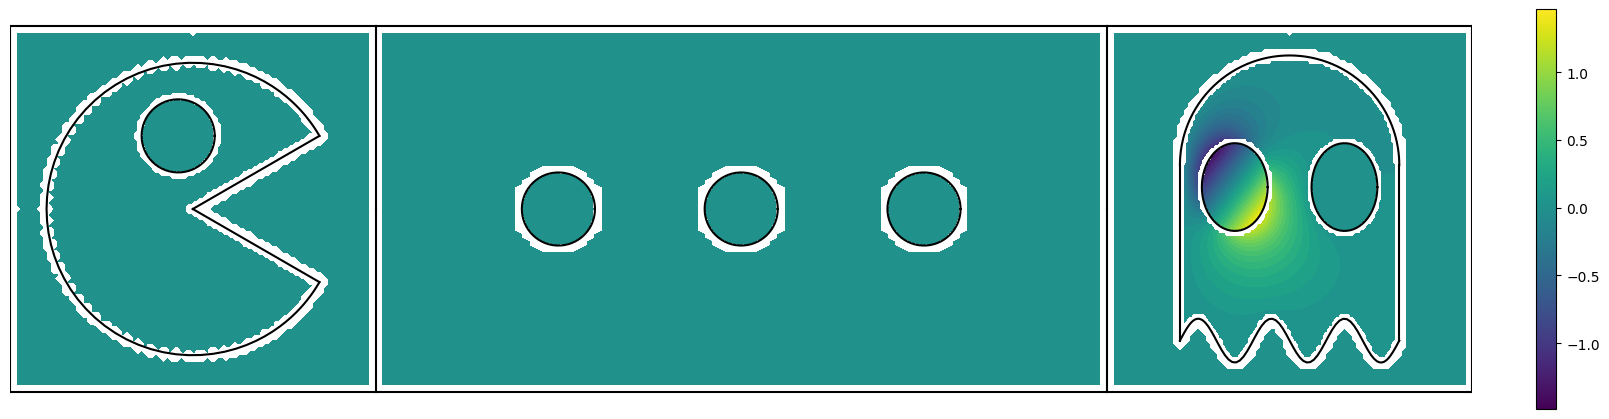

 92%|█████████▏| 35/38 [03:23<00:17,  5.77s/it]

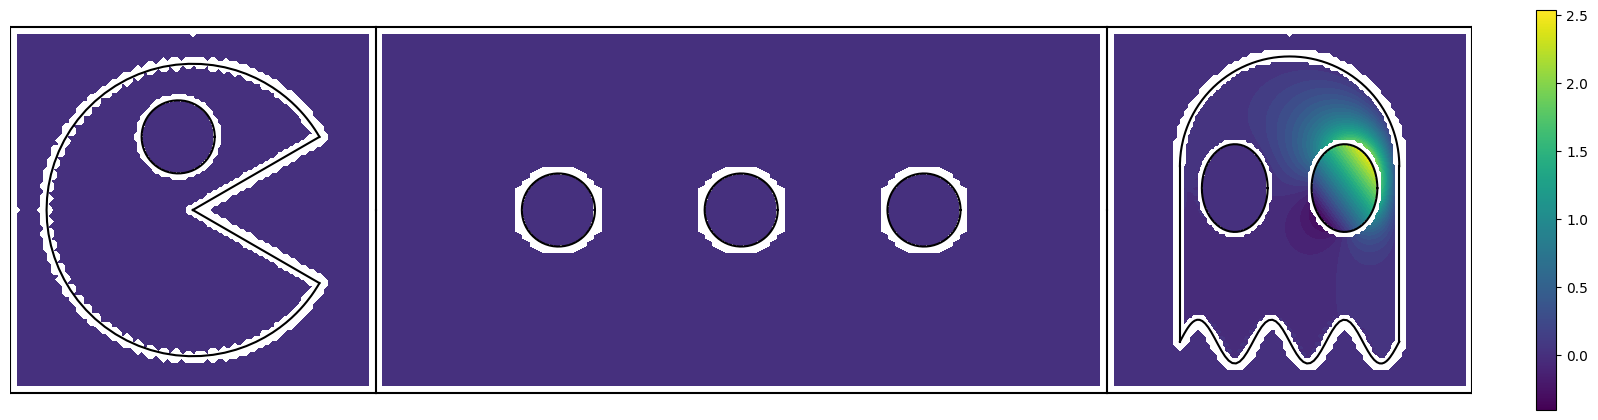

 95%|█████████▍| 36/38 [03:29<00:11,  5.78s/it]

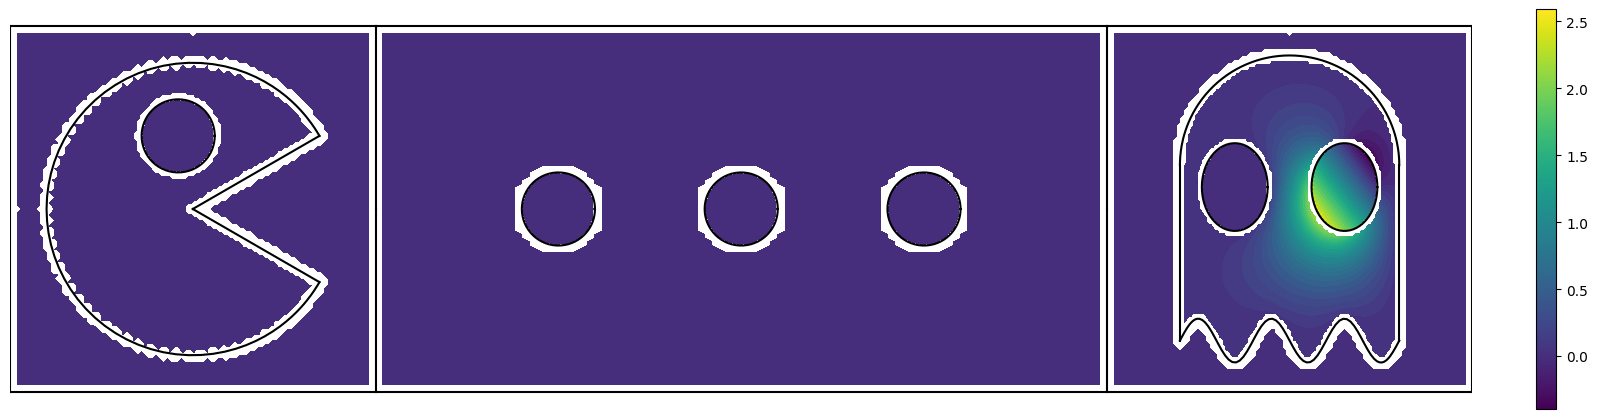

 97%|█████████▋| 37/38 [03:34<00:05,  5.75s/it]

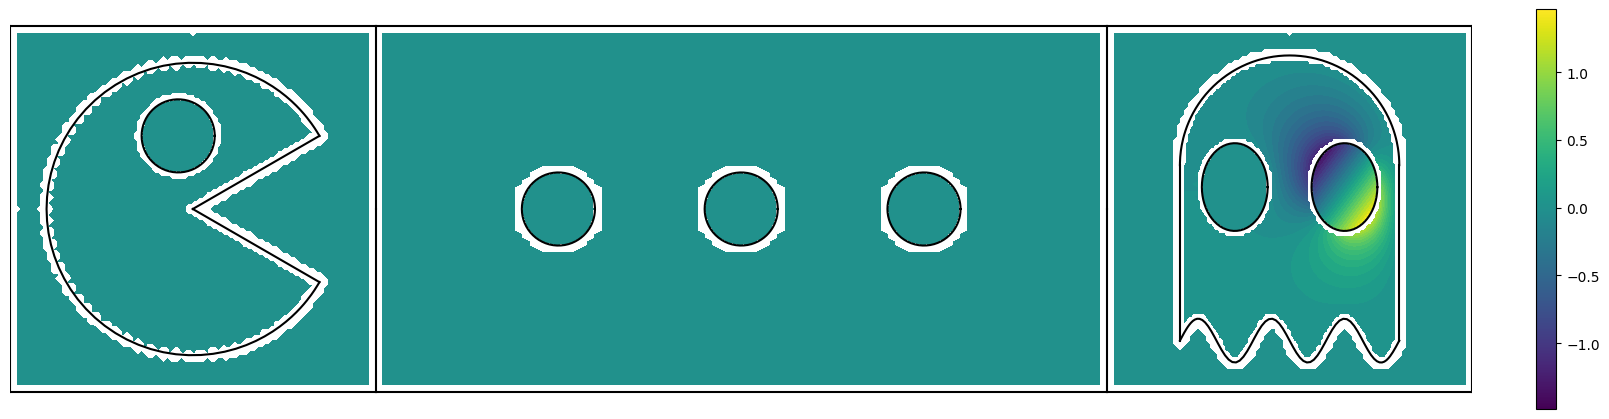

100%|██████████| 38/38 [03:40<00:00,  5.79s/it]


In [12]:
# decide if to use a progress bar
if verbose:
	print('Plotting basis functions...')
	basis_idx_list = tqdm(range(S.num_funs))
else:
	basis_idx_list = range(S.num_funs)

# plot each basis function
for idx in basis_idx_list:
	u = np.zeros(V.num_funs)
	u[idx] = 1.0
	S.plot_linear_combo(
		  u,
		  show_fig=True,
		  save_fig=False,
		  filename='out/png/basis_fun_%d.png'%idx,
		  fill=True,
	)